In [ ]:
# Importing relevant modules.

import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO  # API for COCO dataset.
import skimage.io as io
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

%matplotlib inline

In [ ]:
# Import and mount Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzip the dataset file and store it in a folder called images.

!unzip "/content/drive/MyDrive/Research Methods/Assignment_1/RM_Segmentation_Assignment_dataset.zip" -d "/content/coco2017/"

Archive:  /content/drive/MyDrive/Research Methods/Assignment_1/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/coco2017/test-30/000000001751.jpg  
  inflating: /content/coco2017/test-30/000000001380.jpg  
  inflating: /content/coco2017/test-30/000000001643.jpg  
  inflating: /content/coco2017/test-30/000000001583.jpg  
  inflating: /content/coco2017/test-30/000000001685.jpg  
  inflating: /content/coco2017/test-30/000000001482.jpg  
  inflating: /content/coco2017/test-30/000000001494.jpg  
  inflating: /content/coco2017/test-30/000000001551.jpg  
  inflating: /content/coco2017/test-30/000000001654.jpg  
  inflating: /content/coco2017/test-30/000000001594.jpg  
  inflating: /content/coco2017/test-30/000000001411.jpg  
  inflating: /content/coco2017/test-30/000000001459.jpg  
  inflating: /content/coco2017/test-30/000000001410.jpg  
  inflating: /content/coco2017/test-30/000000001717.jpg  
  inflating: /content/coco2017/test-30/000000001730.jpg  
  inflating: /content/coco20

In [ ]:
# Define location of training data (images and labels).
train_data_path = "/content/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"

# Define location of validation data (images and labels).
val_data_path = "/content/coco2017/validation-300"
val_annotation_file = f"{val_data_path}/labels.json"

# Define location of test data (images)
test_data_path = "/content/coco2017/test-30"

In [ ]:
# Initialising COCO API for training instance annotations.
coco_train = COCO(train_annotation_file)

# Initialising COCO API for validation instance annotations.
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Images in downloaded train folder: 300
Images in downloaded validation folder: 300
Images in downloaded test folder: 30

Images in training dataset: 300
Images in validation dataset: 300
Images in test dataset: 30

Training dataset category counts:
airplane: 15
backpack: 84
banana: 15
baseball bat: 6
baseball glove: 12
bear: 3
bench: 49
bicycle: 125
bird: 57
boat: 20
book: 2
bottle: 10
bowl: 10
broccoli: 1
bus: 91
cake: 13
car: 1061
carrot: 4
cat: 4
cell phone: 19
chair: 51
clock: 17
cow: 1
cup: 21
dining table: 25
dog: 14
donut: 4
elephant: 5
fire hydrant: 9
fork: 6
frisbee: 3
giraffe: 1
handbag: 72
horse: 17
hot dog: 3
kite: 55
knife: 4
laptop: 2
motorcycle: 73
oven: 2
parking meter: 9
person: 1350
pizza: 10
potted plant: 9
refrigerator: 2
remote: 1
sandwich: 6
scissors: 2
skateboard: 30
skis: 11
spoon: 1
sports ball: 23
stop sign: 14
suitcase: 14
surfboard: 15
tennis racket: 7
tie: 12
traffic light: 167
train: 10
truck: 120
umbrella: 68
vase: 1
wine glass: 2

Validation dataset cate

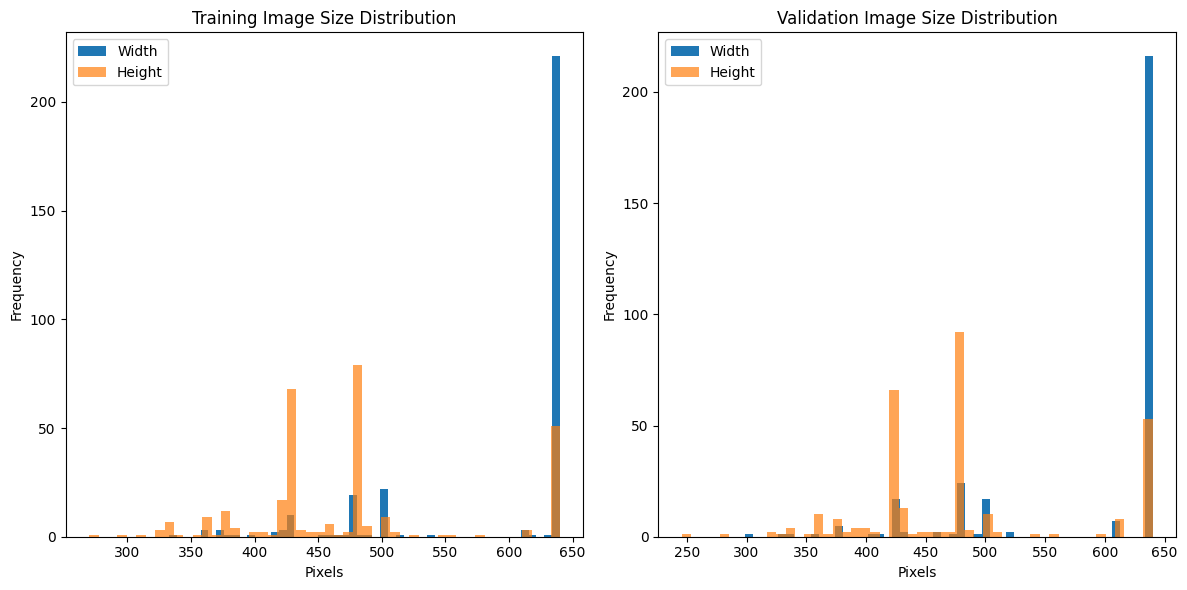

In [ ]:
# How many images are in the downloaded data folders?
# How many images are in our training/validation/test datasets?
# How often does each COCO/target class appear?
# How large are the images? What is their distribution?

import numpy as np
import os

# Count images in downloaded data folders
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']  # Add other extensions if needed
    count = 0
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if any(filename.lower().endswith(ext) for ext in image_extensions):
                count += 1
    return count

train_downloaded_images = count_images_in_folder(os.path.join('/content/coco2017/', 'train-300/data'))
val_downloaded_images = count_images_in_folder(os.path.join('/content/coco2017/', 'validation-300/data'))
test_downloaded_images = count_images_in_folder(os.path.join('/content/coco2017/', 'test-30'))

print(f"Images in downloaded train folder: {train_downloaded_images}")
print(f"Images in downloaded validation folder: {val_downloaded_images}")
print(f"Images in downloaded test folder: {test_downloaded_images}")


# Count images in training/validation/test datasets (assuming these paths are correct after unzipping)
train_dataset_images = count_images_in_folder(f'{train_data_path}/data')
val_dataset_images = count_images_in_folder(f'{val_data_path}/data')
test_dataset_images = count_images_in_folder(test_data_path)

print(f"\nImages in training dataset: {train_dataset_images}")
print(f"Images in validation dataset: {val_dataset_images}")
print(f"Images in test dataset: {test_dataset_images}")

# How often does each COCO/target class appear?
# Get all category ids and names
cats = coco_train.loadCats(coco_train.getCatIds())
cat_names = [cat['name'] for cat in cats]

# Count annotations per category for training data
train_cat_counts = {}
for cat_name in cat_names:
    cat_id = coco_train.getCatIds(catNms=[cat_name])
    img_ids = coco_train.getImgIds(catIds=cat_id)
    ann_ids = coco_train.getAnnIds(imgIds=img_ids, catIds=cat_id)
    train_cat_counts[cat_name] = len(ann_ids)

print("\nTraining dataset category counts:")
for cat, count in train_cat_counts.items():
    print(f"{cat}: {count}")

# Count annotations per category for validation data
val_cat_counts = {}
for cat_name in cat_names:
    cat_id = coco_val.getCatIds(catNms=[cat_name])
    img_ids = coco_val.getImgIds(catIds=cat_id)
    ann_ids = coco_val.getAnnIds(imgIds=img_ids, catIds=cat_id)
    val_cat_counts[cat_name] = len(ann_ids)

print("\nValidation dataset category counts:")
for cat, count in val_cat_counts.items():
    print(f"{cat}: {count}")

# How large are the images? What is their distribution?
# Get image sizes from the training dataset
img_ids_train = coco_train.getImgIds()
img_sizes_train = []
for img_id in img_ids_train:
    img_info = coco_train.loadImgs(img_id)[0]
    img_sizes_train.append((img_info['width'], img_info['height']))

# Get image sizes from the validation dataset
img_ids_val = coco_val.getImgIds()
img_sizes_val = []
for img_id in img_ids_val:
    img_info = coco_val.loadImgs(img_id)[0]
    img_sizes_val.append((img_info['width'], img_info['height']))

# Convert sizes to numpy arrays for easier analysis
img_sizes_train = np.array(img_sizes_train)
img_sizes_val = np.array(img_sizes_val)

print("\nTraining dataset image size statistics:")
print(f"Number of images: {len(img_sizes_train)}")
print(f"Mean size (width, height): {np.mean(img_sizes_train, axis=0)}")
print(f"Median size (width, height): {np.median(img_sizes_train, axis=0)}")
print(f"Min size (width, height): {np.min(img_sizes_train, axis=0)}")
print(f"Max size (width, height): {np.max(img_sizes_train, axis=0)}")

print("\nValidation dataset image size statistics:")
print(f"Number of images: {len(img_sizes_val)}")
print(f"Mean size (width, height): {np.mean(img_sizes_val, axis=0)}")
print(f"Median size (width, height): {np.median(img_sizes_val, axis=0)}")
print(f"Min size (width, height): {np.min(img_sizes_val, axis=0)}")
print(f"Max size (width, height): {np.max(img_sizes_val, axis=0)}")

# Plot distributions (optional but helpful)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(img_sizes_train[:, 0], bins=50, label='Width')
plt.hist(img_sizes_train[:, 1], bins=50, label='Height', alpha=0.7)
plt.title('Training Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(img_sizes_val[:, 0], bins=50, label='Width')
plt.hist(img_sizes_val[:, 1], bins=50, label='Height', alpha=0.7)
plt.title('Validation Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
filtered_classes = ["person", "cake", "dog", "car"]

# Create a DataFrame for training category counts for filtered classes
train_filtered_counts = {cat: count for cat, count in train_cat_counts.items() if cat in filtered_classes}
df_train_filtered = pd.DataFrame(list(train_filtered_counts.items()), columns=['Category', 'Count'])

print("\nTraining dataset filtered category counts:")
print(df_train_filtered)

# Create a DataFrame for validation category counts for filtered classes
val_filtered_counts = {cat: count for cat, count in val_cat_counts.items() if cat in filtered_classes}
df_val_filtered = pd.DataFrame(list(val_filtered_counts.items()), columns=['Category', 'Count'])

print("\nValidation dataset filtered category counts:")
print(df_val_filtered)



Training dataset filtered category counts:
  Category  Count
0     cake     13
1      car   1061
2      dog     14
3   person   1350

Validation dataset filtered category counts:
  Category  Count
0     cake     18
1      car    861
2      dog      9
3   person   1191


In [ ]:
# Number of training images containing the target classes with repetitions
target_classes = ["cake", "car", "dog", "person"]
train_target_classes_IDs = coco_train.getCatIds(catNms=target_classes)
training_images = []

# Iterate over each individual class in the list.
for class_name in target_classes:
    # Get all images containing target class.
    training_images_categories = coco_train.getCatIds(catNms=class_name)
    training_images_IDs = coco_train.getImgIds(catIds=training_images_categories)
    training_images += coco_train.loadImgs(training_images_IDs)

print(
    f"Category IDs of target classes in the validation set: {train_target_classes_IDs}.\nNumber of training images with target classes including repetitions: {len(training_images)}."
)

# Filter out repeated training images.

unique_training_images = []

for i in range(len(training_images)):
    if training_images[i] not in unique_training_images:
        unique_training_images.append(training_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in training data containing the target classes: {len(unique_training_images)}"
)


Category IDs of target classes in the validation set: [15, 16, 25, 41].
Number of training images with target classes including repetitions: 566.
Number of unique images in training data containing the target classes: 300


In [ ]:
target_classes = ["cake", "car", "dog", "person"]
val_target_classes_IDs = coco_val.getCatIds(catNms=target_classes)
val_images = []

# Iterate over each individual class in the list.
for class_name in target_classes:
    # Get all images containing target class.
    val_images_categories = coco_val.getCatIds(catNms=class_name)
    val_images_IDs = coco_val.getImgIds(catIds=val_images_categories)
    val_images += coco_val.loadImgs(val_images_IDs)

print(
    f"Category IDs of target classes in the validation set: {val_target_classes_IDs}.\nNumber of validation images with target classes including repetitions: {len(val_images)}."
)

# Filter out repeated images.

unique_val_images = []

for i in range(len(val_images)):
    if val_images[i] not in unique_val_images:
        unique_val_images.append(val_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in validation data containing the target classes: {len(unique_val_images)}"
)


Category IDs of target classes in the validation set: [14, 15, 24, 41].
Number of validation images with target classes including repetitions: 474.
Number of unique images in validation data containing the target classes: 300


Sample training images:
Image ID: 138, File Name: 000000010318.jpg
[{'id': 1949, 'image_id': 138, 'category_id': 16, 'bbox': [563.34, 187.01, 31.490000000000002, 18.33], 'segmentation': [[582.0, 204.5, 563.0, 204.5, 566.5, 190.0, 584.0, 186.5, 591.0, 191.5, 593.5, 198.0, 582.0, 204.5]], 'area': 577.2117, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 1950, 'image_id': 138, 'category_id': 16, 'bbox': [600.68, 185.05, 28.9, 17.83], 'segmentation': [[618.0, 201.5, 612.0, 198.5, 604.0, 198.5, 602.0, 201.5, 599.5, 199.0, 601.5, 187.0, 619.0, 184.5, 625.0, 187.5, 628.5, 193.0, 627.5, 198.0, 618.0, 201.5]], 'area': 515.2869999999999, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 1951, 'image_id': 138, 'category_id': 16, 'bbox': [536.9, 188.76, 29.57, 20.11], 'segmentation': [[552.0, 207.5, 535.5, 203.0, 535.5, 195.0, 545.0, 187.5, 558.0, 187.5, 565.5, 193.0, 563.5, 201.0, 552.0, 207.5]], 'area': 594.6527, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 1952, 'image_id': 138, 'categor

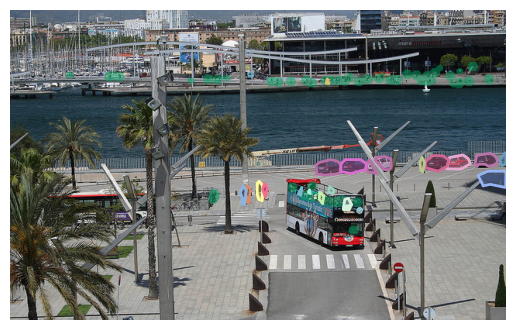

Image ID: 47, File Name: 000000003830.jpg
[{'id': 553, 'image_id': 47, 'category_id': 16, 'bbox': [265.24, 270.6, 111.74000000000001, 46.27], 'segmentation': [[320.0, 315.5, 266.0, 305.5, 264.5, 292.0, 275.5, 283.0, 278.0, 275.5, 318.0, 269.5, 348.0, 269.5, 354.5, 272.0, 375.5, 303.0, 372.0, 309.5, 337.0, 311.5, 320.0, 315.5]], 'area': 5170.2098000000005, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 554, 'image_id': 47, 'category_id': 16, 'bbox': [143.89, 267.57, 91.42, 56.34], 'segmentation': [[163.0, 321.5, 162.0, 312.5, 155.0, 311.5, 149.0, 318.5, 142.5, 313.0, 145.5, 286.0, 160.0, 266.5, 216.0, 267.5, 234.5, 293.0, 233.5, 300.0, 226.0, 303.5, 221.5, 313.0, 216.0, 316.5, 212.0, 309.5, 206.0, 309.5, 167.0, 314.5, 163.0, 321.5]], 'area': 5150.602800000001, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 555, 'image_id': 47, 'category_id': 16, 'bbox': [119.96, 272.2, 33.77, 30.81], 'segmentation': [[126.0, 302.5, 121.5, 299.0, 118.5, 283.0, 120.5, 276.0, 128.0, 272.5, 151.0, 272

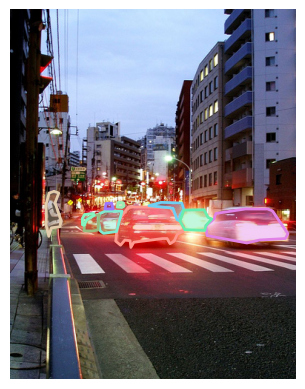

Image ID: 200, File Name: 000000013720.jpg
[{'id': 2803, 'image_id': 200, 'category_id': 16, 'bbox': [567.64, 117.62, 72.36, 98.14], 'segmentation': [[608.0, 214.5, 601.0, 214.5, 597.5, 211.0, 594.5, 204.0, 595.5, 188.0, 580.0, 180.5, 576.5, 163.0, 567.0, 162.5, 566.5, 160.0, 583.5, 146.0, 605.0, 116.5, 636.0, 120.5, 638.5, 122.0, 638.5, 197.0, 617.0, 197.5, 608.0, 214.5]], 'area': 7101.4104, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 2805, 'image_id': 200, 'category_id': 41, 'bbox': [236.02, 121.77999999999999, 16.64, 44.2], 'segmentation': [[246.0, 164.5, 240.5, 163.0, 240.5, 144.0, 235.5, 137.0, 241.5, 128.0, 242.0, 120.5, 248.5, 127.0, 251.5, 140.0, 249.5, 160.0, 246.0, 164.5]], 'area': 735.488, 'iscrowd': 0, 'supercategory': 'person'}]


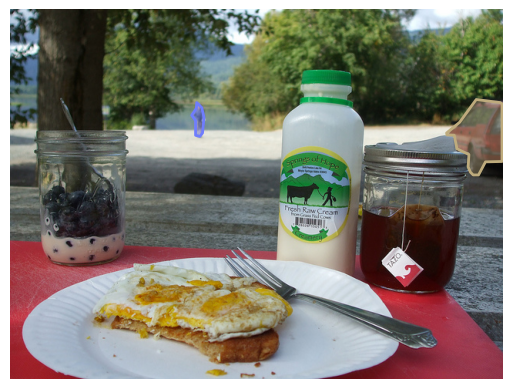

Image ID: 158, File Name: 000000011402.jpg
[{'id': 2193, 'image_id': 158, 'category_id': 16, 'bbox': [285.4, 194.74, 23.83, 18.56], 'segmentation': [[299.0, 212.5, 294.0, 212.5, 284.5, 204.0, 286.0, 194.5, 298.0, 193.5, 302.5, 197.0, 299.0, 212.5], [308.0, 210.5, 307.0, 205.5, 308.0, 210.5]], 'area': 442.28479999999996, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 2194, 'image_id': 158, 'category_id': 16, 'bbox': [373.03, 240.85000000000002, 30.55, 30.32], 'segmentation': [[398.0, 270.5, 385.0, 270.5, 375.5, 260.0, 372.5, 250.0, 375.0, 240.5, 389.0, 239.5, 399.5, 250.0, 401.5, 268.0, 398.0, 270.5]], 'area': 926.2760000000001, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 2195, 'image_id': 158, 'category_id': 16, 'bbox': [411.6, 283.21, 15.4, 22.98], 'segmentation': [[426.0, 305.5, 422.0, 305.5, 410.5, 293.0, 415.0, 284.5, 423.0, 282.5, 426.5, 286.0, 426.0, 305.5]], 'area': 353.892, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 2196, 'image_id': 158, 'category_id': 16, 'bbo

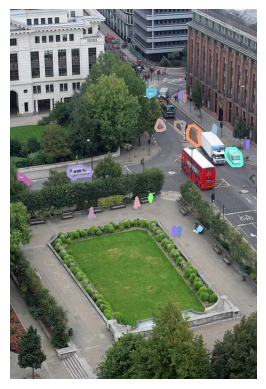

Image ID: 248, File Name: 000000016599.jpg
[{'id': 3374, 'image_id': 248, 'category_id': 16, 'bbox': [32.95, 519.85, 81.38, 49.45], 'segmentation': [[91.0, 568.5, 80.5, 567.0, 81.5, 550.0, 75.0, 533.5, 41.0, 532.5, 36.0, 537.5, 31.5, 534.0, 55.0, 518.5, 109.0, 522.5, 113.5, 527.0, 107.5, 533.0, 111.5, 549.0, 97.0, 567.5, 91.0, 568.5]], 'area': 4024.241, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 3375, 'image_id': 248, 'category_id': 41, 'bbox': [85.85, 528.03, 47.3, 76.37], 'segmentation': [[105.0, 603.5, 85.5, 602.0, 98.5, 596.0, 95.5, 575.0, 109.5, 550.0, 109.5, 544.0, 104.5, 537.0, 108.0, 531.5, 116.0, 527.5, 131.5, 551.0, 132.5, 562.0, 129.0, 573.5, 109.5, 578.0, 105.0, 603.5]], 'area': 3612.301, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 3376, 'image_id': 248, 'category_id': 41, 'bbox': [126.92, 533.28, 31.589999999999996, 75.72], 'segmentation': [[146.0, 608.5, 138.5, 607.0, 141.5, 599.0, 140.0, 582.5, 133.5, 599.0, 133.5, 607.0, 125.5, 606.0, 129.5, 594.0, 131.5, 56

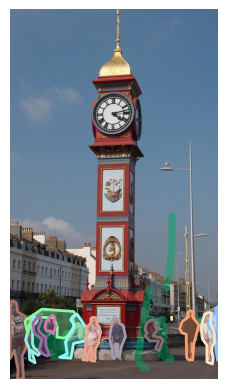

In [ ]:
# Sample view of training images with target classes
# Print 5 images from the training data.
random.seed(0)
print("Sample training images:")
for i in range(5):
    img_info = random.choice(unique_training_images)
    print(f"Image ID: {img_info['id']}, File Name: {img_info['file_name']}")
    img_path = os.path.join(train_data_path, 'data', img_info['file_name'])
    if os.path.exists(img_path):
        I = io.imread(img_path)
        train_image_annotations_ID = coco_train.getAnnIds(
            imgIds=img_info["id"], catIds=train_target_classes_IDs, iscrowd=None)
        train_image_annotation = coco_train.loadAnns(train_image_annotations_ID)
        print(train_image_annotation)
        plt.imshow(I)
        plt.axis('off')
        coco_train.showAnns(train_image_annotation)
        plt.show()
    else:
        print(f"Image file not found: {img_path}")

Sample validation images:
Image ID: 248, File Name: 000000211674.jpg
[{'id': 3147, 'image_id': 248, 'category_id': 15, 'bbox': [184.88, 259.04, 14.71, 9.53], 'segmentation': [[185.0, 267.5, 183.5, 262.0, 187.0, 258.5, 194.0, 258.5, 198.5, 263.0, 197.0, 266.5, 185.0, 267.5]], 'area': 140.1863, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 3149, 'image_id': 248, 'category_id': 41, 'bbox': [284.09, 44.75, 33.69, 40.62], 'segmentation': [[300.0, 84.5, 286.5, 74.0, 283.5, 50.0, 288.0, 47.5, 292.0, 53.5, 298.0, 44.5, 302.0, 43.5, 308.5, 49.0, 310.5, 59.0, 315.5, 65.0, 300.0, 84.5]], 'area': 1368.4877999999999, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 3150, 'image_id': 248, 'category_id': 41, 'bbox': [86.43, 251.98999999999998, 5.25, 13.68], 'segmentation': [[88.0, 264.5, 85.5, 256.0, 90.0, 250.5, 88.0, 264.5]], 'area': 71.82, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 3152, 'image_id': 248, 'category_id': 41, 'bbox': [376.96, 11.12, 40.8, 33.95], 'segmentation': [[415.0, 44

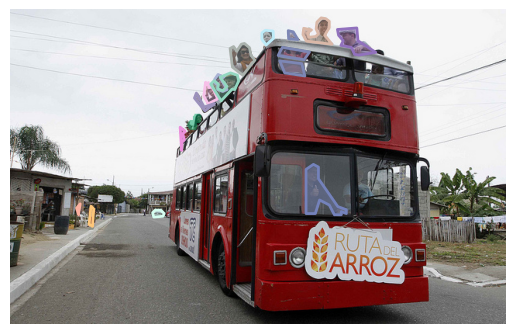

Image ID: 268, File Name: 000000228942.jpg
[{'id': 3389, 'image_id': 268, 'category_id': 15, 'bbox': [539.07, 124.51, 100.93, 110.40000000000002], 'segmentation': [[639.0, 233.5, 548.0, 221.5, 542.5, 212.0, 542.5, 189.0, 538.5, 172.0, 547.5, 154.0, 601.0, 143.5, 639.0, 123.5, 639.0, 233.5]], 'area': 11142.672000000002, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 3390, 'image_id': 268, 'category_id': 15, 'bbox': [0.94, 133.06, 379.93, 165.43], 'segmentation': [[213.0, 297.5, 191.0, 297.5, 168.0, 285.5, 155.0, 269.5, 55.0, 246.5, 43.0, 264.5, 21.0, 259.5, 11.5, 240.0, 0, 230.0, 0, 180.0, 8.0, 170.5, 28.0, 164.5, 68.0, 141.5, 125.0, 132.5, 212.0, 136.5, 263.0, 165.5, 270.0, 164.5, 278.0, 177.5, 318.0, 183.5, 366.0, 201.5, 379.5, 226.0, 375.5, 251.0, 372.0, 256.5, 308.0, 276.5, 262.0, 284.5, 236.0, 282.5, 213.0, 297.5]], 'area': 62851.8199, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 3393, 'image_id': 268, 'category_id': 41, 'bbox': [542.98, 121.07, 16.91, 36.44], 'segmentation

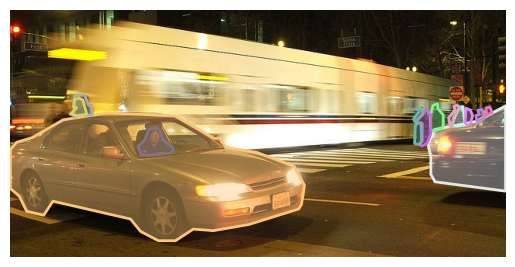

Image ID: 21, File Name: 000000018837.jpg
[{'id': 167, 'image_id': 21, 'category_id': 41, 'bbox': [327.57, 14.59, 139.46, 143.79], 'segmentation': [[465.0, 157.5, 447.0, 157.5, 434.5, 140.0, 410.5, 120.0, 402.0, 104.5, 379.0, 99.5, 361.0, 101.5, 356.0, 113.5, 343.5, 108.0, 326.5, 73.0, 338.5, 49.0, 364.0, 13.5, 375.0, 13.5, 377.5, 16.0, 376.5, 42.0, 390.5, 53.0, 393.5, 75.0, 397.5, 78.0, 400.5, 89.0, 437.0, 123.5, 452.5, 124.0, 454.5, 144.0, 465.0, 157.5]], 'area': 20052.9534, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 168, 'image_id': 21, 'category_id': 41, 'bbox': [294.3, 21.62, 48.17, 101.51], 'segmentation': [[339.0, 122.5, 311.0, 118.5, 305.5, 107.0, 293.5, 98.0, 309.5, 62.0, 316.5, 56.0, 316.0, 53.5, 310.5, 55.0, 299.5, 41.0, 296.5, 31.0, 299.0, 27.5, 308.0, 28.5, 308.5, 23.0, 312.0, 20.5, 329.0, 25.5, 329.5, 32.0, 341.5, 44.0, 335.5, 46.0, 337.5, 50.0, 327.5, 74.0, 341.5, 102.0, 339.0, 122.5]], 'area': 4889.7367, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 169, 'image

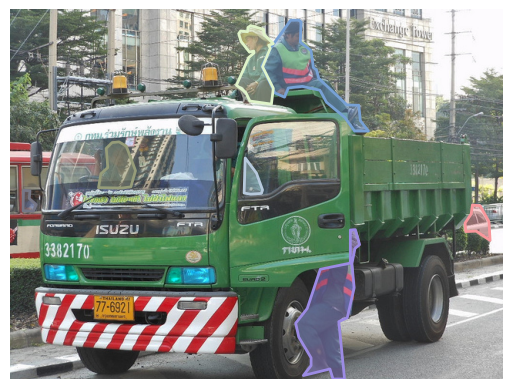

Image ID: 164, File Name: 000000147223.jpg
[{'id': 1972, 'image_id': 164, 'category_id': 15, 'bbox': [1.55, 156.34, 148.19, 137.32], 'segmentation': [[4.0, 291.5, 0.5, 291.0, 1.0, 156.5, 56.0, 157.5, 81.0, 170.5, 105.0, 196.5, 131.5, 198.0, 145.5, 221.0, 148.5, 232.0, 142.5, 243.0, 145.5, 250.0, 138.5, 258.0, 137.5, 269.0, 132.0, 274.5, 114.0, 274.5, 105.0, 268.5, 4.0, 291.5]], 'area': 20349.4508, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 1973, 'image_id': 164, 'category_id': 15, 'bbox': [42.68, 141.86, 115.16999999999999, 57.989999999999995], 'segmentation': [[141.0, 198.5, 117.0, 198.5, 108.0, 195.5, 98.5, 185.0, 93.5, 174.0, 83.0, 166.5, 62.0, 156.5, 41.5, 153.0, 65.0, 144.5, 112.0, 140.5, 142.0, 145.5, 152.5, 156.0, 156.5, 179.0, 153.5, 190.0, 141.0, 198.5]], 'area': 6678.708299999998, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 1975, 'image_id': 164, 'category_id': 15, 'bbox': [583.42, 103.79000000000002, 12.04, 26.83], 'segmentation': [[584.0, 129.5, 583.0, 102.5, 5

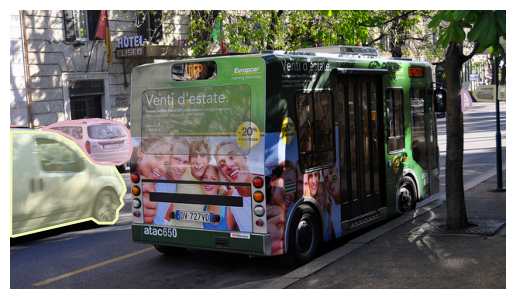

Image ID: 121, File Name: 000000114884.jpg
[{'id': 1362, 'image_id': 121, 'category_id': 41, 'bbox': [319.39, 85.76, 167.83, 239.54], 'segmentation': [[459.0, 324.5, 390.0, 324.5, 389.5, 306.0, 396.5, 272.0, 390.0, 264.5, 383.5, 265.0, 386.5, 271.0, 381.0, 274.5, 368.0, 275.5, 361.0, 269.5, 355.0, 275.5, 346.0, 278.5, 338.0, 289.5, 323.0, 283.5, 319.5, 277.0, 330.0, 261.5, 351.5, 259.0, 373.5, 228.0, 396.5, 206.0, 415.5, 180.0, 419.5, 164.0, 412.5, 148.0, 403.5, 140.0, 403.5, 115.0, 408.5, 95.0, 423.0, 84.5, 460.5, 92.0, 467.5, 103.0, 486.5, 167.0, 482.5, 232.0, 471.5, 251.0, 465.5, 269.0, 463.5, 296.0, 456.5, 313.0, 459.0, 324.5]], 'area': 40201.9982, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 1363, 'image_id': 121, 'category_id': 41, 'bbox': [371.01, 104.69, 19.76, 47.22999999999999], 'segmentation': [[379.0, 150.5, 372.5, 149.0, 375.5, 144.0, 370.5, 127.0, 373.0, 103.5, 378.5, 104.0, 378.0, 111.5, 381.0, 110.5, 389.5, 116.0, 380.5, 124.0, 380.5, 138.0, 385.5, 144.0, 383.0, 146

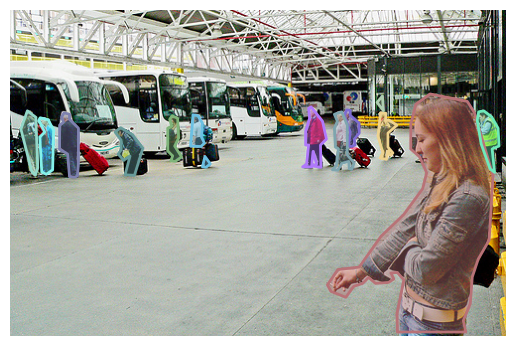

In [ ]:
# Sample view of validation images with target classes
# Print 5 images from the validation data.
random.seed(0)
print("Sample validation images:")
for i in range(5):
    val_img_info = random.choice(unique_val_images)
    print(f"Image ID: {val_img_info['id']}, File Name: {val_img_info['file_name']}")
    img_path = os.path.join(val_data_path, 'data', val_img_info['file_name'])
    if os.path.exists(img_path):
        I = io.imread(img_path)
        val_image_annotations_ID = coco_val.getAnnIds(
            imgIds=val_img_info["id"], catIds=val_target_classes_IDs, iscrowd=None)
        val_image_annotation = coco_val.loadAnns(val_image_annotations_ID)
        print(val_image_annotation)
        plt.imshow(I)
        plt.axis('off')
        coco_val.showAnns(val_image_annotation)
        plt.show()
    else:
        print(f"Image file not found: {img_path}")

{'id': 34, 'file_name': '000000002782.jpg', 'height': 480, 'width': 640, 'license': None, 'coco_url': None}


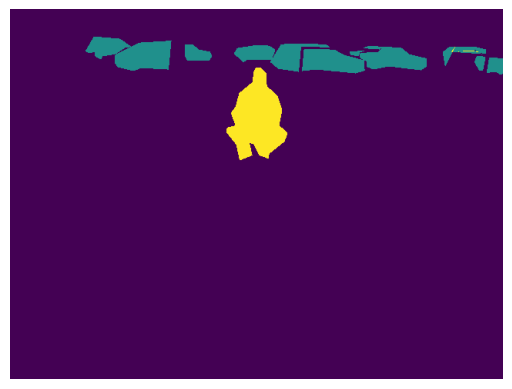

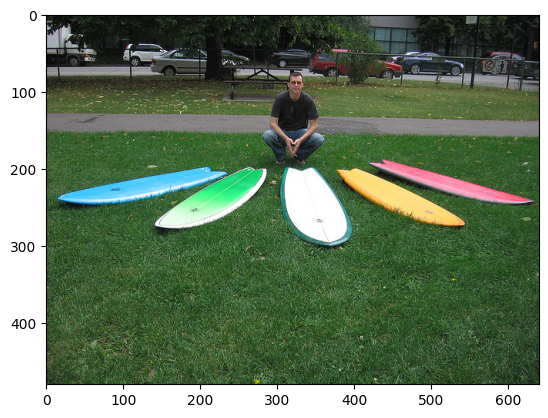

In [ ]:
# Example of masking and displaying the mask on the image
training_image = unique_training_images[2]
print(training_image)

image = io.imread(f'{train_data_path}/data/{training_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

cat_ids = coco_train.getCatIds(catNms=['car', 'dog', 'person', 'cake'])
anns_ids = coco_train.getAnnIds(imgIds=training_image['id'], catIds=cat_ids, iscrowd=None)
anns = coco_train.loadAnns(anns_ids)
mask = coco_train.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_train.annToMask(anns[i])

plt.imshow(mask)

plt.figure()
plt.imshow(image)


Sample test images:
File Name: 000000001654.jpg


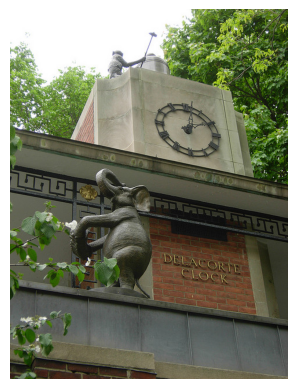

File Name: 000000001657.jpg


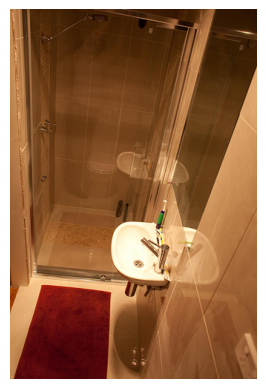

File Name: 000000001600.jpg


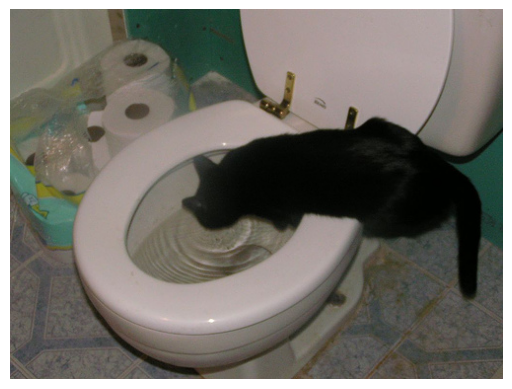

File Name: 000000001773.jpg


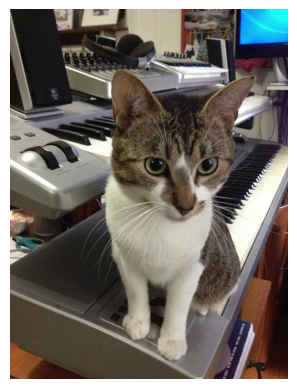

File Name: 000000001385.jpg


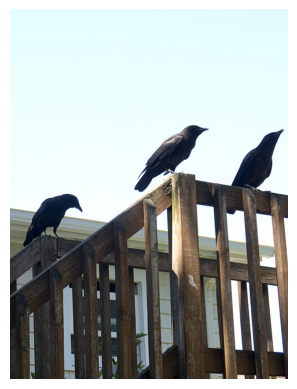

In [ ]:
# Display test images
print("\nSample test images:")
# Get a list of all files in the test directory
test_image_files = [f for f in os.listdir(test_data_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list to pick random images
random.seed(0)
random.shuffle(test_image_files)

# Print and display 5 test images
for i in range(min(5, len(test_image_files))):
    test_img_file = test_image_files[i]
    test_img_path = os.path.join(test_data_path, test_img_file)
    print(f"File Name: {test_img_file}")
    if os.path.exists(test_img_path):
        I = io.imread(test_img_path)
        plt.imshow(I)
        plt.axis('off')
        plt.show()
    else:
        print(f"Test image file not found: {test_img_path}")


Preprocessing training data to size (256, 256)...
Finished preprocessing 300 training images.

Preprocessing validation data to size (256, 256)...
Finished preprocessing 300 validation images.

Shapes of processed data:
Training Images: (300, 256, 256, 3)
Training Masks: (300, 256, 256)
Validation Images: (300, 256, 256, 3)
Validation Masks: (300, 256, 256)


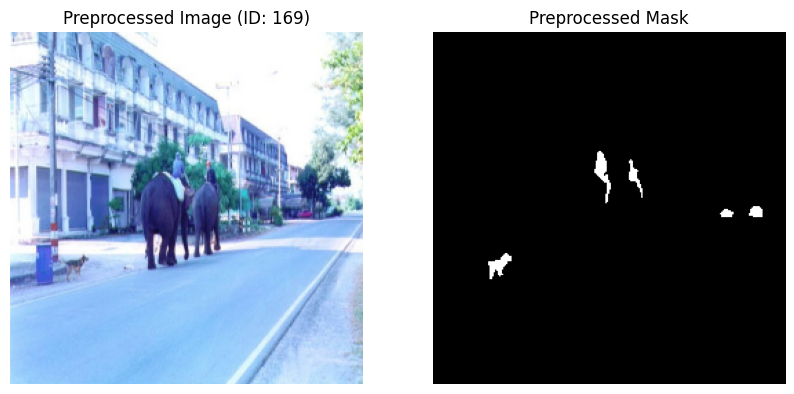

In [ ]:
# Data Preprocessing Steps

# Define target image size for resizing
target_size = (256, 256)

#Create functions for image and mask preprocessing
def preprocess_image(image_path, target_size):
  """Loads and resizes an image."""
  try:
    image = io.imread(image_path)
    # Convert to RGB if not already (some images might be grayscale)
    if image.ndim == 2:
      image = np.stack((image,) * 3, axis=-1)
    # Resize image
    from skimage.transform import resize
    resized_image = resize(image, target_size, anti_aliasing=True)
    return resized_image
  except Exception as e:
    print(f"Error processing image {image_path}: {e}")
    return None

def create_combined_mask(coco_api, img_info, cat_ids, target_size):
  """Creates a combined binary mask for all annotations of specified categories in an image."""
  try:
    ann_ids = coco_api.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
    anns = coco_api.loadAnns(ann_ids)

    if not anns:
      # Return an empty mask if no annotations for target classes are found
      return np.zeros(target_size, dtype=np.uint8)

    # Create a combined mask from all annotations
    mask = coco_api.annToMask(anns[0])
    for i in range(1, len(anns)):
        mask += coco_api.annToMask(anns[i])

    # Ensure mask is binary (values are 0 or 1)
    mask[mask > 0] = 1

    # Resize the mask to the target size (use order=0 for nearest neighbor to keep binary)
    from skimage.transform import resize
    resized_mask = resize(mask, target_size, order=0, anti_aliasing=False)

    return resized_mask.astype(np.uint8) # Return as uint8

  except Exception as e:
    print(f"Error creating mask for image {img_info['file_name']}: {e}")
    return np.zeros(target_size, dtype=np.uint8)

# Prepare data lists for training and validation
# These lists will store dictionaries containing processed image and mask data
train_processed_data = []
val_processed_data = []

print(f"\nPreprocessing training data to size {target_size}...")
for img_info in unique_training_images:
    img_path = os.path.join(train_data_path, 'data', img_info['file_name'])
    preprocessed_img = preprocess_image(img_path, target_size)
    if preprocessed_img is not None:
        # Create mask for target classes
        cat_ids_train = coco_train.getCatIds(catNms=target_classes)
        preprocessed_mask = create_combined_mask(coco_train, img_info, cat_ids_train, target_size)

        train_processed_data.append({
            'image': preprocessed_img,
            'mask': preprocessed_mask,
            'image_info': img_info # Keep original info for debugging/reference
        })

print(f"Finished preprocessing {len(train_processed_data)} training images.")

print(f"\nPreprocessing validation data to size {target_size}...")
for val_img_info in unique_val_images:
    img_path = os.path.join(val_data_path, 'data', val_img_info['file_name'])
    preprocessed_img = preprocess_image(img_path, target_size)
    if preprocessed_img is not None:
        # Create mask for target classes
        cat_ids_val = coco_val.getCatIds(catNms=target_classes)
        preprocessed_mask = create_combined_mask(coco_val, val_img_info, cat_ids_val, target_size)

        val_processed_data.append({
            'image': preprocessed_img,
            'mask': preprocessed_mask,
            'image_info': val_img_info # Keep original info for debugging/reference
        })

print(f"Finished preprocessing {len(val_processed_data)} validation images.")


# Data Augmentation (Optional but recommended)
# Depending on the library used (e.g., Albumentations, TensorFlow Data),
# you would define and apply augmentations here.
# Example using a placeholder:
# def apply_augmentation(image, mask):
#    # Implement augmentation logic (e.g., random flips, rotations, color jitter)
#    return augmented_image, augmented_mask

# 5. Convert to suitable format for deep learning framework (e.g., NumPy arrays or tensors)
train_images_array = np.array([item['image'] for item in train_processed_data])
train_masks_array = np.array([item['mask'] for item in train_processed_data]) # Masks might need an extra channel depending on framework

val_images_array = np.array([item['image'] for item in val_processed_data])
val_masks_array = np.array([item['mask'] for item in val_processed_data]) # Masks might need an extra channel depending on framework

# For example, if using TensorFlow/Keras for binary segmentation, masks often need a channel dimension
# train_masks_array = np.expand_dims(train_masks_array, axis=-1)
# val_masks_array = np.expand_dims(val_masks_array, axis=-1)


print("\nShapes of processed data:")
print(f"Training Images: {train_images_array.shape}")
print(f"Training Masks: {train_masks_array.shape}")
print(f"Validation Images: {val_images_array.shape}")
print(f"Validation Masks: {val_masks_array.shape}")


# Display a preprocessed image and its mask
if train_processed_data:
    sample_data = random.choice(train_processed_data)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(sample_data['image'])
    plt.title(f"Preprocessed Image (ID: {sample_data['image_info']['id']})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_data['mask'], cmap='gray') # Display binary mask
    plt.title("Preprocessed Mask")
    plt.axis('off')

    plt.show()

# The processed arrays (train_images_array, train_masks_array, etc.) are now ready
# to be used for training a deep learning model.

In [ ]:
# Helper function for encoder block
def encoder_block(inputs, filters, pool_size=(2, 2), dropout_rate=0.0):
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    if dropout_rate > 0:
        conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool

# Helper function for bottleneck block
def bottleneck_block(inputs, filters, dropout_rate=0.0):
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    if dropout_rate > 0:
        conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    return conv

# Helper function for decoder block
def decoder_block(inputs, skip_connection, filters, up_size=(2, 2)):
    up = Conv2D(filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=up_size)(inputs))
    merge = concatenate([skip_connection, up], axis=3)
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
# Define the U-Net model architecture
def build_unet_model(input_size=(256, 256, 3)):
    """Builds the U-Net model architecture with refactored blocks."""
    inputs = Input(input_size)

    # Encoder
    conv1, pool1 = encoder_block(inputs, 64)
    conv2, pool2 = encoder_block(pool1, 128)
    conv3, pool3 = encoder_block(pool2, 256)
    conv4, pool4 = encoder_block(pool3, 512, dropout_rate=0.5)

    # Bottleneck
    conv5 = bottleneck_block(pool4, 1024, dropout_rate=0.5)

    # Decoder
    conv6 = decoder_block(conv5, conv4, 512)
    conv7 = decoder_block(conv6, conv3, 256)
    conv8 = decoder_block(conv7, conv2, 128)
    conv9 = decoder_block(conv8, conv1, 64)


    # Output layer for binary segmentation (one channel, sigmoid activation)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

def compile_model(model):
    """Compiles the U-Net model."""
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    return model

In [ ]:
def train_model(model, train_images, train_masks, val_images, val_masks, epochs=20, batch_size=32):
    """Trains the U-Net model."""
    # Add channel dimension to masks if needed for binary crossentropy loss
    if model.output_shape[-1] == 1 and train_masks.ndim == 3:
        train_masks_for_training = np.expand_dims(train_masks, axis=-1)
        val_masks_for_training = np.expand_dims(val_masks, axis=-1)
    elif model.output_shape[-1] == 1 and train_masks.ndim == 4 and train_masks.shape[-1] == 1:
         train_masks_for_training = train_masks
         val_masks_for_training = val_masks
    else:
        print("Mask shape does not match model output shape. Check mask dimensions.")
        train_masks_for_training = train_masks
        val_masks_for_training = val_masks


    # Use early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("\nStarting model training...")
    history = model.fit(train_images, train_masks_for_training,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(val_images, val_masks_for_training),
                         callbacks=[early_stopping])

    print("Training finished.")
    return history

def plot_training_history(history):
    """Plots the training history (loss and accuracy/IoU)."""
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy or MeanIoU
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy during Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
    elif 'mean_io_u' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_io_u'], label='Training MeanIoU')
        plt.plot(history.history['val_mean_io_u'], label='Validation MeanIoU')
        plt.title('Mean IoU during Training')
        plt.xlabel('Epoch')
        plt.ylabel('Mean IoU')
        plt.legend()
        plt.grid(True)


    plt.tight_layout()
    plt.show()

In [ ]:
unet_model = build_unet_model(input_size=train_images_array.shape[1:])
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_model = compile_model(unet_model)
history = train_model(unet_model, train_images_array, train_masks_array, val_images_array, val_masks_array, epochs=20, batch_size=32)


Starting model training...
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 292s 18s/step - accuracy: 0.8474 - loss: 0.5270 - mean_io_u: 0.4299 - val_accuracy: 0.8584 - val_loss: 0.4170 - val_mean_io_u: 0.4292
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8600 - loss: 0.4139 - mean_io_u: 0.4300 - val_accuracy: 0.8584 - val_loss: 0.4147 - val_mean_io_u: 0.4292
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8773 - loss: 0.3687 - mean_io_u: 0.4386 - val_accuracy: 0.8584 - val_loss: 0.4098 - val_mean_io_u: 0.4292
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8683 - loss: 0.3798 - mean_io_u: 0.4341 - val_accuracy: 0.8584 - val_loss: 0.4046 - val_mean_io_u: 0.4292
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8764 - loss: 0.3571 - mean_io_u: 0.4382 - val_accuracy: 0.8584 - val_loss: 0.3958 - val_mean_io_u: 0.4292
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8746 - loss: 0.3657 - mean_io_u: 0.4373 - val_accuracy: 

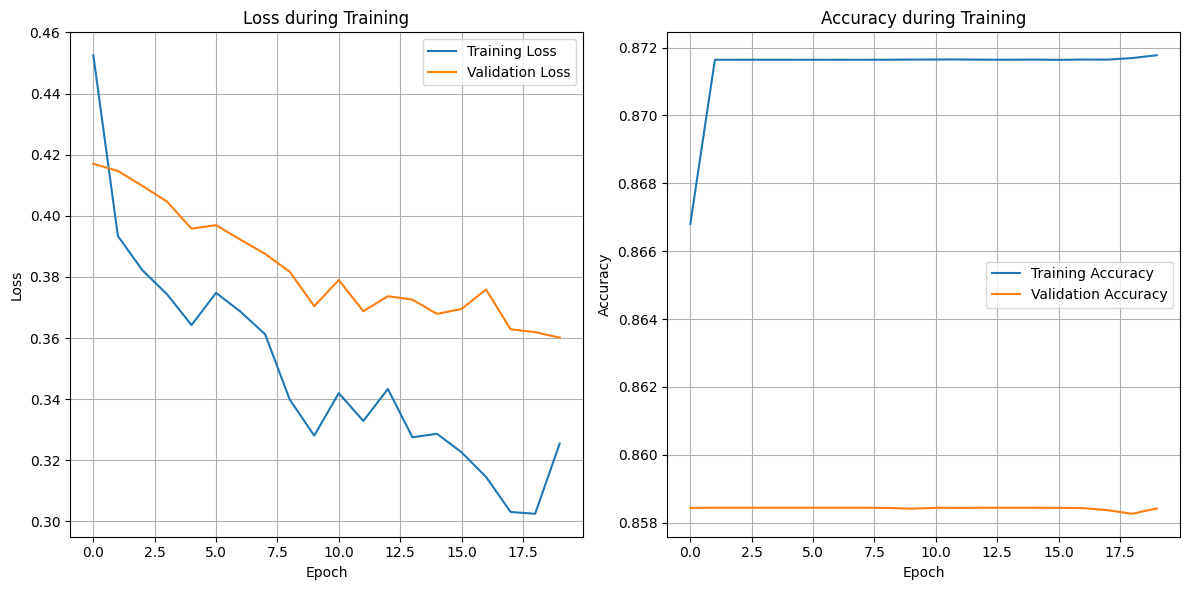

Model saved to Google Drive.


In [ ]:
plot_training_history(history)

# Save the trained model
unet_model.save('/content/drive/MyDrive/Research Methods/Assignment_1/unet_segmentation_model.h5')
print("Model saved to Google Drive.")

In [ ]:
# Preprocess test images

test_processed_data = []

print(f"\nPreprocessing test data to size {target_size}...")
# Get a list of all files in the test directory
test_image_files = [f for f in os.listdir(test_data_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for test_img_file in test_image_files:
    test_img_path = os.path.join(test_data_path, test_img_file)
    preprocessed_img = preprocess_image(test_img_path, target_size)
    if preprocessed_img is not None:
        test_processed_data.append({
            'image': preprocessed_img,
            'image_info': {'file_name': test_img_file} # Store file name for reference
        })

print(f"Finished preprocessing {len(test_processed_data)} test images.")

# Convert to numpy array
test_images_array = np.array([item['image'] for item in test_processed_data])

print("\nShapes of processed test data:")
print(f"Test Images: {test_images_array.shape}")


Preprocessing test data to size (256, 256)...
Finished preprocessing 30 test images.

Shapes of processed test data:
Test Images: (30, 256, 256, 3)



Making predictions on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Finished making predictions.
Shape of predicted masks: (30, 256, 256, 1)

Sample test images with predicted masks:


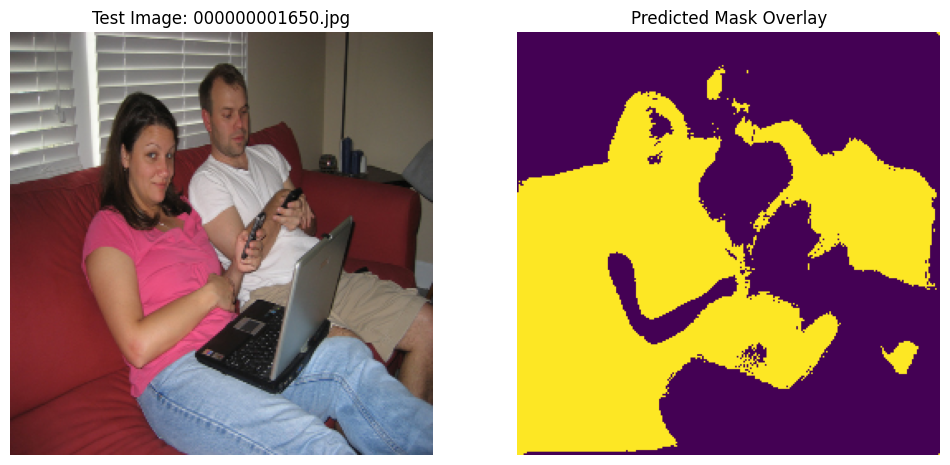

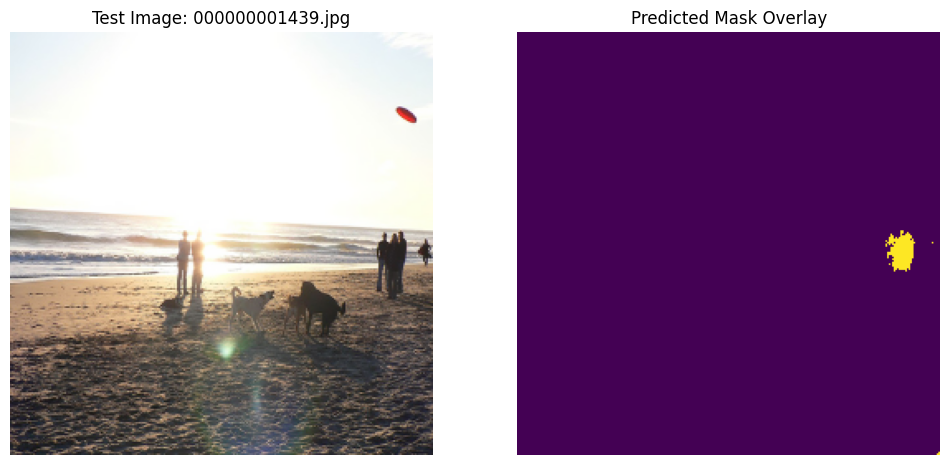

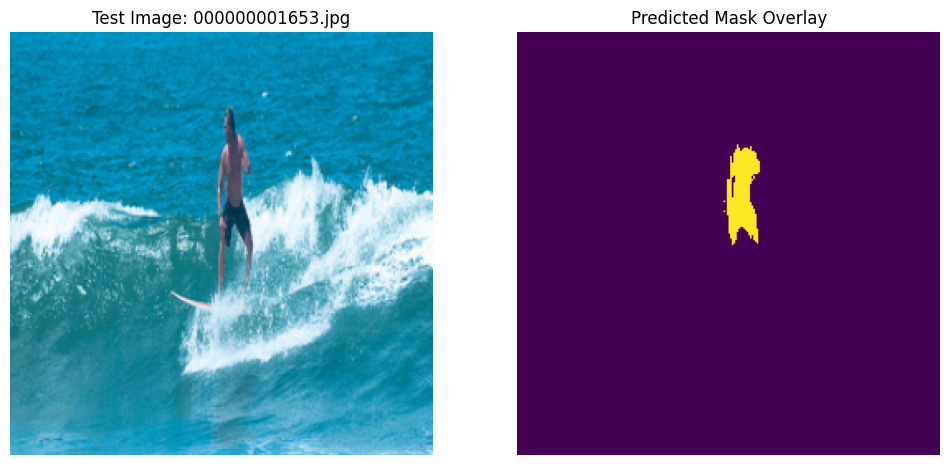

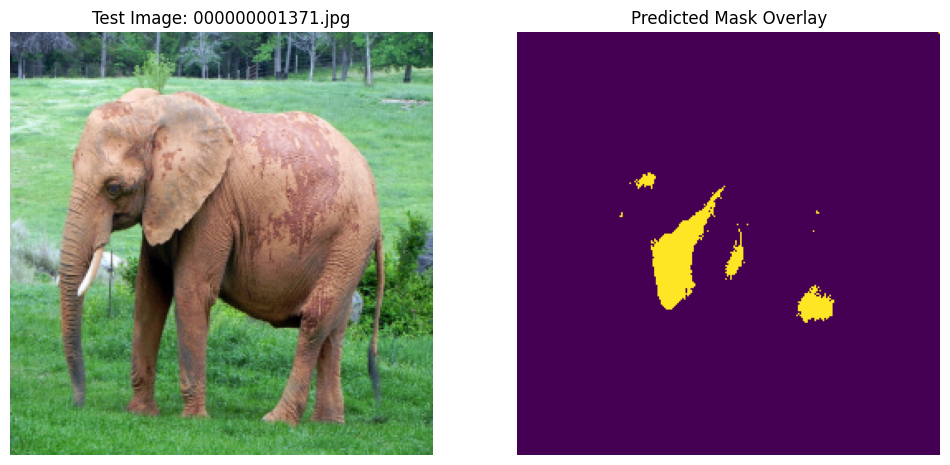

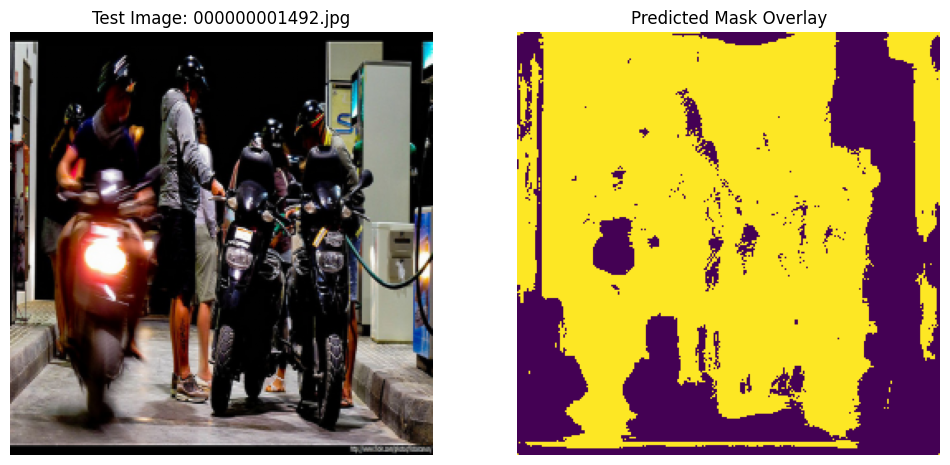

In [ ]:
# Evaluate the model on the test set

# The test set does not have masks, so we can only evaluate the model's performance
# by predicting masks and visually inspecting them or by using metrics
# that don't require ground truth masks (which are not standard for segmentation).
# A common approach is to predict and visualize, or if you had a small
# subset of test data with masks, evaluate on that.

# Since we don't have ground truth masks for the provided test-30 dataset,
# we will proceed with making predictions and visualizing them as the primary
# form of "evaluation" for this test set.

print("\nMaking predictions on test images...")
predictions = unet_model.predict(test_images_array)

# The predictions are probabilities (due to sigmoid activation), convert to binary mask
predicted_masks = (predictions > 0.275).astype(np.uint8)

print("Finished making predictions.")
print(f"Shape of predicted masks: {predicted_masks.shape}")

# Visualize some test images with their predicted masks
print("\nSample test images with predicted masks:")
import random

random.seed(0)
sample_indices = random.sample(range(len(test_processed_data)), min(5, len(test_processed_data)))

for i in sample_indices:
    img_info = test_processed_data[i]['image_info']
    original_img = test_processed_data[i]['image'] # Use the preprocessed image for display
    predicted_mask = predicted_masks[i, :, :, 0] # Remove the channel dimension for displaying the mask

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Test Image: {img_info['file_name']}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_img) # Show the original image underneath the mask
    plt.imshow(predicted_mask, cmap='viridis') # Overlay the predicted mask with transparency
    plt.title("Predicted Mask Overlay")
    plt.axis('off')


    plt.show()